In [ ]:
import os
import torch
from prepare_datasets import prepare_datasets
from build_dataloader import set_seed
from perform_grid_search import perform_grid_search
from train_test import train, validate
from model import GAT
from model_GCN import GCN
from explainer import explain_model
from build_dataloader import GraphDataset, collate_fn
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, f1_score
from performance_visualizations import plot_hyperparameter_boxplots
from perform_cv_early_stopping import perform_cv_early_stopping
import pandas as pd

In [5]:
# Set random seed for reproducibility
set_seed(42)
base_dir = os.path.dirname(os.getcwd())

In [6]:
# Prepare datasets
datasets, feature_names_sc, feature_names_combined = prepare_datasets(base_dir, test_size = 0.15, random_state = 42)

In [7]:
dataset_name = 'sc_fc'
train_graphs = datasets[f'train_graphs_{dataset_name}']
train_labels = datasets[f'train_labels_{dataset_name}']
test_graphs = datasets[f'test_graphs_{dataset_name}']
test_labels = datasets[f'test_labels_{dataset_name}']

In [8]:
param_grid_1 = { 
    'num_heads': [1,2,3],
    'out_channels': [8],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0]
}

Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 1, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 54 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 27 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 35 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 17 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 18 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 2, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 50 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 27 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 74 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 14 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 14 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 3, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping

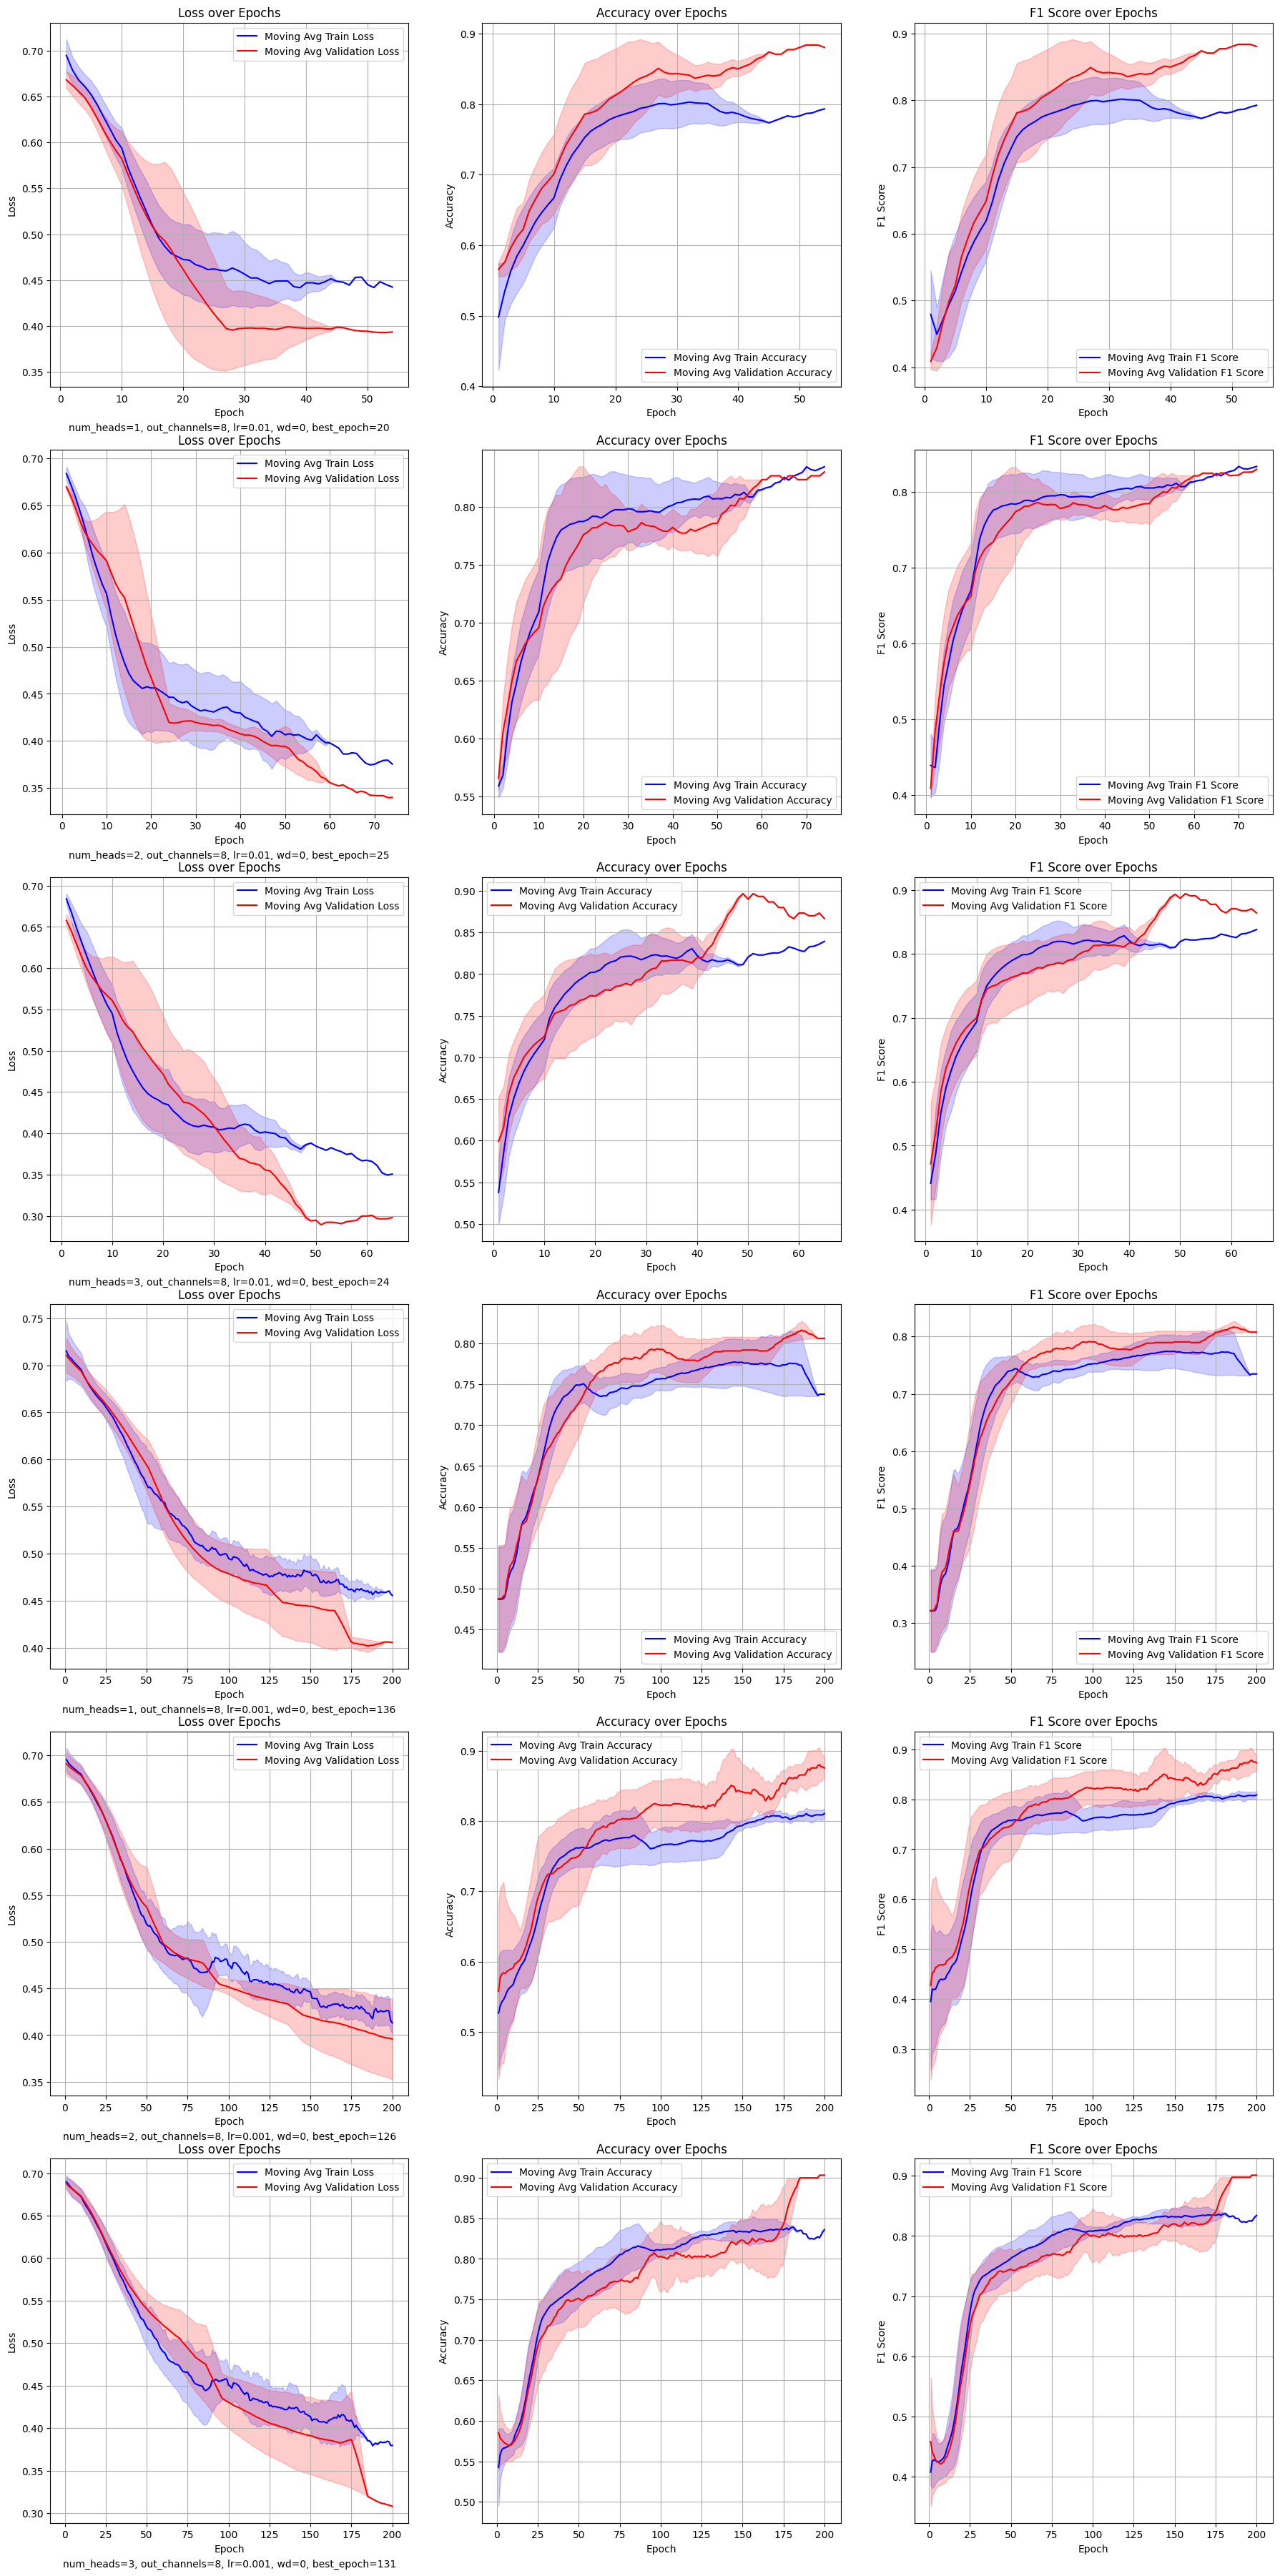

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    model_class=GAT,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 300
)



In [11]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params_1)
print(f"Best Average Validation F1 Score: {best_val_f1_1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy_1}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 3.0, 'out_channels': 8.0, 'learning_rate': 0.01, 'weight_decay': 0.0}
Best Average Validation F1 Score: 0.8063380135610861
Best Average Validation Accuracy: 0.8090322580645161


In [12]:
# Save results_df to a CSV file for later analysis
results_df_1.to_csv('first_grid_search_sc_combined.csv', index=False)


In [9]:

import pandas as pd
results_df = pd.read_csv('first_grid_search_sc_combined.csv')

from performance_visualizations import get_top_results

top_results_df_1 = get_top_results(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'weight_decay', 'out_channels'],
    metric='val_f1',
    percentile=50,
    print_flag=True
)

# Group by 'fold' and calculate the mean for each fold
fold_means_df = results_df.groupby('fold').mean().reset_index()

print(fold_means_df)

c:\Users\barbo\brain classifier repo\brain_classifier\src1\performance_visualizations.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_results_df[hyperparameters] = top_results_df[hyperparameters].round(3)


,fold,val_f1,learning_rate,num_heads,weight_decay,out_channels
0,1,0.903635,0.010,1,0,8
20,1,0.902598,0.001,2,0,8
12,3,0.897532,0.010,3,0,8
27,3,0.861563,0.001,3,0,8
11,2,0.838027,0.010,3,0,8
21,2,0.838027,0.001,2,0,8
6,2,0.838027,0.010,2,0,8
1,2,0.838027,0.010,1,0,8
22,3,0.829221,0.001,2,0,8
2,3,0.824176,0.010,1,0,8


   fold  num_heads  out_channels  learning_rate  weight_decay  best_epoch  \
0     1        2.0           8.0         0.0055           0.0   91.333333   
1     2        2.0           8.0         0.0055           0.0   73.333333   
2     3        2.0           8.0         0.0055           0.0   99.000000   
3     4        2.0           8.0         0.0055           0.0   36.166667   
4     5        2.0           8.0         0.0055           0.0   44.000000   

   train_loss  val_loss  train_accuracy  val_accuracy  train_f1    val_f1  
0    0.426022  0.394821        0.801653      0.833333  0.800514  0.832964  
1    0.441378  0.418178        0.804408      0.817204  0.802873  0.815299  
2    0.404096  0.350815        0.822404      0.838889  0.820568  0.835415  
3    0.479468  0.564829        0.810109      0.700000  0.802327  0.697377  
4    0.529526  0.544704        0.763661      0.716667  0.760136  0.711388  


In [ ]:
# Train the best model on all data

# Set the best hyperparameters
best_params_1 = {
    'num_heads': 3,
    'out_channels': 8,
    'learning_rate': 0.01,
    'weight_decay': 0
}


Epoch 1/24: Loss: 0.6694, F1: 0.4345
Epoch 2/24: Loss: 0.6222, F1: 0.5528
Epoch 3/24: Loss: 0.5789, F1: 0.7093
Epoch 4/24: Loss: 0.5348, F1: 0.7453
Epoch 5/24: Loss: 0.4904, F1: 0.7817
Epoch 6/24: Loss: 0.4990, F1: 0.7715
Epoch 7/24: Loss: 0.4735, F1: 0.7984
Epoch 8/24: Loss: 0.4564, F1: 0.7949
Epoch 9/24: Loss: 0.4395, F1: 0.7886
Epoch 10/24: Loss: 0.4477, F1: 0.8000
Epoch 11/24: Loss: 0.4197, F1: 0.8076
Epoch 12/24: Loss: 0.4154, F1: 0.8145
Epoch 13/24: Loss: 0.4077, F1: 0.8070
Epoch 14/24: Loss: 0.4247, F1: 0.8405
Epoch 15/24: Loss: 0.4042, F1: 0.8209
Epoch 16/24: Loss: 0.4066, F1: 0.8150
Epoch 17/24: Loss: 0.3943, F1: 0.8209
Epoch 18/24: Loss: 0.3901, F1: 0.8209
Epoch 19/24: Loss: 0.3989, F1: 0.8336
Epoch 20/24: Loss: 0.3866, F1: 0.8266
Epoch 21/24: Loss: 0.4382, F1: 0.8214
Epoch 22/24: Loss: 0.3882, F1: 0.8354
Epoch 23/24: Loss: 0.3791, F1: 0.8527
Epoch 24/24: Loss: 0.3757, F1: 0.8336


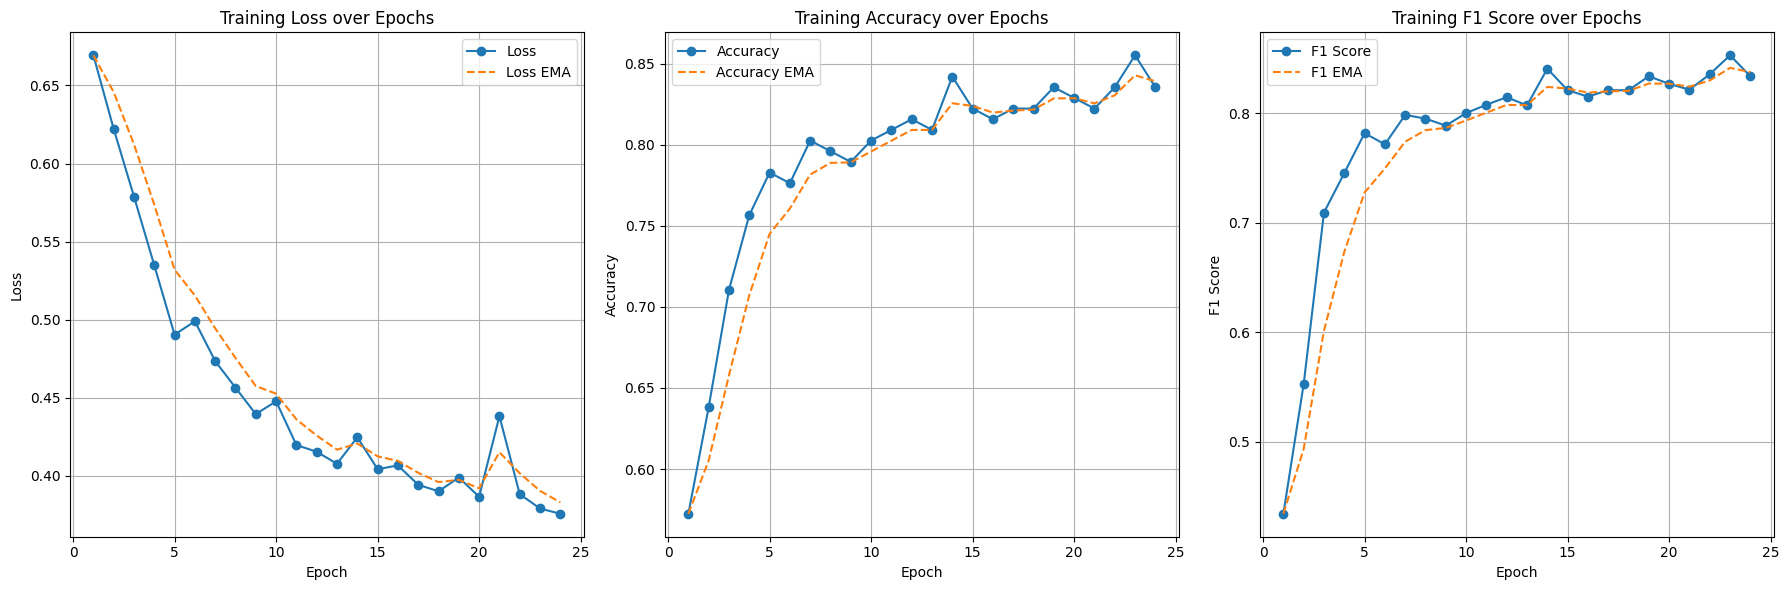

In [ ]:

# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc_fc',
    best_params = best_params_1, 
    model_class = GAT,
    max_epochs = 24, 
    batch_size=8, 
    device = device)

In [ ]:
from prepare_datasets import compute_feature_means_stds, compute_edge_attr_means_stds, normalize_graph_features, normalize_graph_edge_weights

train_mean_x, train_std_x = compute_feature_means_stds(train_graphs)
train_mean_edge_attr, train_std_edge_attr = compute_edge_attr_means_stds(train_graphs)

In [ ]:


best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc_fc.pth')


from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels,
    model_class=GAT,
    train_mean_x=train_mean_x,
    train_std_x=train_std_x,
    train_mean_edge_attr=train_mean_edge_attr,
    train_std_edge_attr=train_std_edge_attr,
    batch_size=8
)


Test Loss: 0.2909, Test Accuracy: 0.8889, Test F1: 0.8892


In [ ]:
# Benchmarking with GCN

from model_GCN import GCN

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    model_class=GCN,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 200
)


In [ ]:
# Set the best hyperparameters
best_params_2 = {
    'num_heads': 3,
    'out_channels': 8,
    'learning_rate': 0.01,
    'weight_decay': 0
}

In [ ]:
# Train the best model on all data
# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc_fc_gcn',
    best_params = best_params_2, 
    model_class=GCN,
    max_epochs = 24, 
    batch_size=8, 
    device = device)

In [ ]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc_fc_gcn.pth')


from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels,
    model_class=GCN,
    train_mean_x=train_mean_x,
    train_std_x=train_std_x,
    train_mean_edge_attr=train_mean_edge_attr,
    train_std_edge_attr=train_std_edge_attr,
    batch_size=8
)
